In [1]:
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
from evaluation_functions import ensemble_evaluation_functions as eef
import sunspots.sunspots as sunspots

import matplotlib as mpl
import os

import huxt as H
import huxt_analysis as HA
import huxt_inputs as Hin

import scipy.interpolate
from scipy import integrate
from scipy.optimize import curve_fit

from sunpy.coordinates.sun import carrington_rotation_time
from sunpy.coordinates.sun import carrington_rotation_number
import astropy.units as u

from sklearn.calibration import calibration_curve
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error

In [32]:
def read_deterministic_forecast_cdf(cr):
    ### Reads in deterministic forecast runs
    input_file = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_forecasting\\data\\deterministic_forecasts\\deterministic_CR{cr}.nc'

    # Read the NetCDF file into an xarray Dataset
    loaded_ds = xr.open_dataset(input_file)

    df = loaded_ds.sel().to_dataframe()

    return df

def compute_roc_score(roc_curve):
    """
    Computes integrates area under ROC curve using scipy quad returning integrated area as the ROC score

    Parameters:
    - roc_curve (list): list of tuples which each contain the hit rate and false alarm rate calculated at different thresholds

    Returns:
    - result (float): ROC Score calculated as the integrated area under ROC curve
    """

    # Unpack and prepare roc curve data
    y,x = zip(*roc_curve)

    x = np.array([xx for xx in x])
    y = np.array([yy for yy in y])

    nan_mask_x = ~np.isnan(x)
    nan_mask_y = ~np.isnan(y)

    nan_mask = np.logical_and(nan_mask_x, nan_mask_y)

    x = x[nan_mask]
    y = y[nan_mask]

    # Interpolate the curve
    interp_function = scipy.interpolate.interp1d(x, y, kind='linear')

    # Define the integration limits
    a = min(x)
    b = max(x)

    # Perform the integration
    result, error = integrate.quad(interp_function, a, b)

    return result


def interpolate_and_resample(observed_data_index, forecast_index, forecast):
    
    # This function runs an interpolation algorithm on forecast output and outputs a resamples forecast series on the omni data timestep
    Int = scipy.interpolate.CubicSpline(forecast_index, forecast)

    interpolated_forecast_output = Int(observed_data_index)

    return interpolated_forecast_output


def perturb_longitude(long_pert_dt, ensemble_member):
    
    # Ensure that the DataFrame has a datetime index
    if not isinstance(ensemble_member.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a datetime index")
    
    shift_amount = int(long_pert_dt.to(u.second).value) # Convert shift amount into seconds

    # Convert datetime index into integers
    numeric_index = ensemble_member.index.astype(int) // 10**9 # Floor division to convert into seconds (UNIX int datetime is in nanoseconds)
    numeric_index = numeric_index.to_numpy()

    # Calculate the new index by shifting with wrapping
    shifted_index = numeric_index + shift_amount

    # Generate boolean array which captures elements above and below max/min indices
    wrap_mask = (shifted_index < numeric_index.min()) | (shifted_index > numeric_index.max())
  
    if shift_amount < 0:
        # If negative shift amount (i.e. elements will be below min index)
        shifted_index[wrap_mask] = shifted_index[wrap_mask] + (shifted_index.max() - shifted_index.min())

    elif shift_amount > 0:
        # If positive shift amount (i.e. elements will be above max index)  
        shifted_index[wrap_mask] = shifted_index[wrap_mask] - (shifted_index.max() - shifted_index.min())

    else:
        # No change -- preserve original index
        shifted_index = numeric_index

    # Convert back to datetime index
    new_converted_index = pd.to_datetime(shifted_index, unit='s')

    # Sort the DataFrame based on the new index
    df_shifted = ensemble_member.copy()
    df_shifted = (df_shifted.sort_index().set_index(new_converted_index)).sort_index()
    df_shifted = df_shifted[~(df_shifted.index).duplicated()].copy()

    # Interpolate shifted dataframe back onto orignal datetime axis (for more ease in later analysis)
    Int = scipy.interpolate.CubicSpline(df_shifted.index, df_shifted['vsw'])
    data_time_axis = ensemble_member.index
    interpolated_forecast_output = Int(data_time_axis)
    
    return pd.DataFrame({'vsw':interpolated_forecast_output}, index = data_time_axis)


def gen_ranked_ensemble(ensemble_members, omni_data): 

    vsw_list = [] # Initialise list for forecast output

    # Prepare data for rank comparison
    omni_chunk = omni_data.loc[pd.to_datetime(ensemble_members[0].index[0]):pd.to_datetime(ensemble_members[0].index[-1])]
 
    omni_chunk = omni_chunk.dropna(subset = ['V']) # Remove rows with NaN values

    # Interpolate and resample forecast output onto OMNI data time step
    for vsw in ensemble_members:
        vsw_int = interpolate_and_resample(observed_data_index = omni_chunk.index, forecast_index=vsw.index, forecast=vsw['vsw'])
        vsw_list.append(vsw_int)

    # Compare ensemble member output arrays to omni data 
    vsw_arr = np.array(vsw_list)
    ranked_forecast_boolean = np.array([vsw < omni_chunk['V'] for vsw in vsw_arr])
    summed_ranks = np.sum(ranked_forecast_boolean, axis = 0)
    
    return summed_ranks

def calculate_rank_chi_square(ensemble_size, ranked_forecasts):
        
    ensemble_hist = np.histogram(ranked_forecasts, bins = ensemble_size)[0]

    chi_sq_alt = 0 
    
    for i in range(ensemble_size):
        
        chi_sq_alt += (ensemble_hist[i]/np.sum(ensemble_hist) - 1/(ensemble_size+1))**2

    chi_sq_alt = chi_sq_alt*np.sum(ensemble_hist)*(ensemble_size+1)

    return chi_sq_alt

def chi_rank_over_longitude_range(ensemble_sets, long_min, long_max, increments, ensemble_size):

    rng = np.random.default_rng()
    
    carrington_rotation = 27.2753*u.day
    long_pert_var_list = np.linspace(long_min, long_max, increments) # Define range of longitude variances to perturb by
    chi_square_across_longitude = np.ones(increments)

    # Loop through each CR set and longitudinally peturb each ensemble member whilst retaining ensemble set structure
    for i, long_pert_var in enumerate(long_pert_var_list):
        
        lp_ensemble_sets = [] # list to store sets of longitudinally perturbed ensemble members per CR
        ranked_ensemble_sets = [] # list of ranked ensemble sets per CR

        for ensemble_members in ensemble_sets:

            lp_ensemble_members = [] # list to store longitudinally perturbed ensemble members

            # Loop through each ensemble member to perturb in longitude
            for df in ensemble_members:
                
                # Randomly generate perturbation amount
                long_pert = rng.normal(loc = 0, scale = long_pert_var, size = 1)
                long_pert_dt = ((long_pert * carrington_rotation.value) / 360) * u.day # Convert perturbation amount to a unit of days

                # perturb ensemble member 
                shifted_df = perturb_longitude(long_pert_dt=long_pert_dt, ensemble_member=df)
                lp_ensemble_members.append(shifted_df)
            
            # rank ensemble output against data
            ranked_ensemble_sets.append(gen_ranked_ensemble(ensemble_members=lp_ensemble_members, omni_data = omni_data))
            lp_ensemble_sets.append(lp_ensemble_members)
        
        # calculate chi squared for combined rank histograms for time frame
        rank_chi_square = calculate_rank_chi_square(ensemble_size=ensemble_size, ranked_forecasts=np.concatenate(ranked_ensemble_sets))
        chi_square_across_longitude[i] = rank_chi_square

    return chi_square_across_longitude

def save_chi_arr_to_file(chi_set_list, era_key):
    fname = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_Calibration\\data\\rank_analysis\\rank_hist_{era_key}.csv'
    np.savetxt(fname = fname, X = chi_set_list, delimiter = ',')
    return


def brier_ROC_score_across_longitude(observed_data, long_min, long_max, increments, event_threshold, probability_threshold, ensemble_size):

    rng = np.random.default_rng()

    CR_chunk = CR_era_dict[era_key] # one year of carrington rotations
    lat_dev = 15 
    carrington_rotation = 27.2753*u.day
    event_threshold = 500 # km/s

    ensemble_sets = [] # List to store each CR ensemble set 
    data_chunks = [] # List to store data chunk associated with each CR

    # Read in ensemble members per CR
    for CR in CR_chunk:

        ensemble_members = eef.read_ens_cdf_var(cr=CR, var_dev = lat_dev, no_members=ensemble_size)
        ensemble_members = [df.set_index('datetime') for df in ensemble_members]
        ensemble_sets.append(ensemble_members)

        CR_start = pd.Timestamp(carrington_rotation_time(CR).to_datetime()).round('60min')
        CR_end = CR_start + pd.Timedelta(carrington_rotation.value, unit = 'days')
        data_chunks.append(observed_data.loc[CR_start:CR_end])

    # combining data frame will be useful later on
    combined_data = pd.concat(data_chunks)

    long_pert_var_list = np.linspace(long_min, long_max, increments) # degrees 
    carrington_rotation = 27.2753*u.day
    
    brier_score_across_longitude = np.ones(len(long_pert_var_list))
    ROC_score_across_longitude = np.ones(len(long_pert_var_list))

    # Loop through each CR set and longitudinally peturb each ensemble member whilst retaining ensemble set structure
    for k, long_pert_var in enumerate(long_pert_var_list):

        lp_ensemble_sets = [] # list to store sets of longitudinally perturbed ensemble members per CR

        # Loop through each CR set and longitudinally peturb each ensemble member whilst retaining ensemble set structure
        for i, ensemble_members in enumerate(ensemble_sets):

            lp_ensemble_members = []

            for df in ensemble_members:

                # Perturb ensemble member in longitude
                long_pert = rng.normal(loc = 0, scale = long_pert_var, size = 1)
                long_pert_dt = ((long_pert * carrington_rotation.value) / 360) * u.day
                shifted_df = perturb_longitude(long_pert_dt=long_pert_dt, ensemble_member=df)

                # resample perturbed ensemble member onto omni data timestep
                Shifted_Int = scipy.interpolate.CubicSpline(shifted_df.index, shifted_df['vsw'])
                resampled_shifted_df = pd.DataFrame({'vsw':Shifted_Int(data_chunks[i].index)}, index = data_chunks[i].index)
                lp_ensemble_members.append(resampled_shifted_df)
            
            lp_ensemble_sets.append(lp_ensemble_members)

        ## Longitudinally perturbed ensemble members
        combined_lp_ensemble_members = []

        # Create a new list of lists
        for jj in range(ensemble_size):
            list_of_cr_members = [sublist[jj]['vsw'] for sublist in lp_ensemble_sets]
            combined_lp_ensemble_members.append(pd.concat(list_of_cr_members))

        brier_score_across_longitude[k] = eef.compute_brier_score_probabilistic(ensemble_members=combined_lp_ensemble_members, observed_data=combined_data['V'], 
                                                                                    threshold=event_threshold, ensemble_size=ensemble_size)
        
        roc_curve = eef.generate_roc_curve_from_ensemble(ensemble_members=combined_lp_ensemble_members, observed_data=combined_data['V'], 
                                                    threshold_range=(200,800), threshold_num=30, probability_threshold = probability_threshold)

        ROC_score_across_longitude[k] = compute_roc_score(roc_curve=roc_curve)

    return brier_score_across_longitude, ROC_score_across_longitude

def save_brier_scores_to_file(brier_scores, era_key, event_threshold):
    fname = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_Calibration\\data\\forecast_evaluation\\brier_scores_{era_key}_{event_threshold}.csv'
    np.savetxt(fname = fname, X = brier_scores, delimiter = ',')
    return

def save_roc_scores_to_file(roc_scores, era_key, prob_thresh):
    fname = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_Calibration\\data\\forecast_evaluation\\roc_scores_{era_key}_{int(prob_thresh*10)}.csv'
    np.savetxt(fname = fname, X = roc_scores, delimiter = ',')
    return

def read_brier_scores_file(era_key, event_thresh):
    fname = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_Calibration\\data\\forecast_evaluation\\brier_scores_{era_key}_{event_thresh}.csv'
    return np.genfromtxt(fname = fname, delimiter=',')

def read_rank_hist_file(era_key):
    fname = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_Calibration\\data\\rank_analysis\\rank_hist_{era_key}.csv'
    return np.genfromtxt(fname = fname, delimiter=',')

def read_ROC_scores_file(era_key, prob_thresh):
    fname = f'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_Calibration\\data\\forecast_evaluation\\roc_scores_{era_key}_{int(prob_thresh*10)}.csv'
    return np.genfromtxt(fname = fname, delimiter=',')


In [3]:
# omni data directory
omni_data_dir = 'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_Calibration\\data\\OMNI\\Processed_omni\\'

# load the data into dataframe and index by datetime
omni_data = pd.read_hdf(omni_data_dir + 'omni_1hour.h5')
omni_data = omni_data.set_index('datetime')
omni_data = omni_data.dropna(subset = ['V']) # Remove rows with NaN values

In [24]:
# Load sunspot number data
filepath = 'C:\\Users\\ct832900\\Desktop\\Research_Code\\Ensemble_Calibration\\data\\SN_m_tot_V2.0.csv'
ssn = sunspots.LoadSSN(filepath = filepath)

# Start and end date of solar cycle 24
solar_start = datetime.date.fromisoformat('2008-12-01')
solar_end = datetime.date.fromisoformat('2020-01-01')

# Isolate solar cycle 24 in sunspot number data
solar_cycle_24 = ssn.set_index('datetime')
solar_cycle_24 = solar_cycle_24[solar_start:solar_end]

# isolate solar min/max/intermediate values by solar activity index
solar_min_mask = solar_cycle_24['sai'] < 0.33
solar_min_mask = solar_min_mask[solar_min_mask!=0]

solar_max_mask = solar_cycle_24['sai']  > 0.66
solar_max_mask = solar_max_mask[solar_max_mask!=0]

solar_other_mask = (solar_cycle_24['sai'] >= 0.33) & (solar_cycle_24['sai'] <= 0.66)
solar_other_mask = solar_other_mask[solar_other_mask!=0]

# get carrington rotations of each section of solar cycle
solar_min_CR_list = np.unique(np.round(carrington_rotation_number(solar_min_mask.index),0).astype(int))
solar_max_CR_list = np.unique(np.round(carrington_rotation_number(solar_max_mask.index),0).astype(int))
solar_other_CR_list = np.unique(np.round(carrington_rotation_number(solar_other_mask.index),0).astype(int))

# create dictionary for use later
solar_era_dict = {'min':solar_min_CR_list, 'other':solar_other_CR_list, 'max':solar_max_CR_list}
CR_chunk_key = ['min', 'other', 'max']

In [22]:
# Find indices where the value changes from 0 to 1 or 1 to 0
change_indices = np.where(np.diff(solar_other_mask.astype(int)) != 0)[0] + 1

# Split the boolean array into chunks of consecutive 1's and 0's
chunks = np.split(solar_other_mask, change_indices)

# Find the start and end indices of consecutive 1's
start_end_indices = [(i[0], i[-1]) for i in chunks if i[0]]

datetime
2008-12-15    True
2009-01-15    True
2009-02-15    True
2009-03-15    True
2009-04-15    True
              ... 
2019-09-15    True
2019-10-15    True
2019-11-15    True
2019-12-15    True
2020-01-15    True
Name: sai, Length: 65, dtype: bool

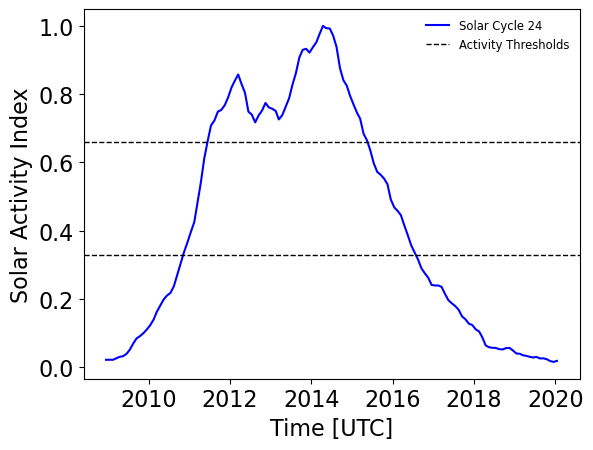

In [21]:
# Sample data
timestamps = [('2024-03-21 08:00:00', '2024-03-21 10:00:00'),
              ('2024-03-21 12:00:00', '2024-03-21 14:00:00'),
              ('2024-03-21 16:00:00', '2024-03-21 18:00:00'),
              ('2024-03-21 20:00:00', '2024-03-21 22:00:00'),
              ('2024-03-21 23:00:00', '2024-03-22 01:00:00')]

# Convert timestamps to datetime objects
timestamps = [(pd.to_datetime(begin), pd.to_datetime(end)) for begin, end in timestamps]

# Create x-axis numerical values
x_values = [begin.timestamp() for begin, _ in timestamps]
x_values.append(timestamps[-1][1].timestamp())  # Add the end timestamp of the last shaded region


# Shade regions
for begin, end in timestamps:
    plt.fill_betweenx([0, 1], begin.timestamp(), end.timestamp(), color='gray', alpha=0.3)

# Set x-axis ticks as timestamps
#plt.xticks(x_values, [begin.strftime('%H:%M') for begin, _ in timestamps] + [timestamps[-1][1].strftime('%H:%M')])

plt.plot(solar_cycle_24['sai'], label = 'Solar Cycle 24', color = 'blue')
plt.axhline(0.33, lw = 1, linestyle = '--', color = 'black', label = 'Activity Thresholds')
plt.axhline(0.66, lw = 1, linestyle = '--', color = 'black')
plt.legend(frameon = False, loc = 'upper right', fontsize = 'small')
plt.xlabel('Time [UTC]')
plt.ylabel('Solar Activity Index')
plt.show()


In [28]:
ensemble_size = 100

for key in CR_chunk_key:  

    # Latitude perturbation parameters
    lat_dev_list = [0,5,10,15,20,25,30,35,40]

    CR_chunk = solar_era_dict[key] # List of CR associated with given solar era

    chi_set_list = []

    for lat_dev in lat_dev_list:

        ensemble_sets = [] # List to store each CR ensemble set 

        # Read in ensemble members per CR
        for CR in CR_chunk:
            ensemble_members = eef.read_ens_cdf_var(cr=CR, var_dev = lat_dev, no_members=ensemble_size)
            ensemble_members = [df.set_index('datetime') for df in ensemble_members]
            ensemble_sets.append(ensemble_members)

        chi_list = chi_rank_over_longitude_range(ensemble_sets=ensemble_sets, long_min = min(lat_dev_list), 
                                                 long_max=max(lat_dev_list), increments=len(lat_dev_list), ensemble_size=ensemble_size)
        chi_set_list.append(chi_list)

    save_chi_arr_to_file(chi_set_list=chi_set_list, era_key=key)

In [41]:

rank_histogram_grids = [read_rank_hist_file(key) for key in CR_chunk_key]


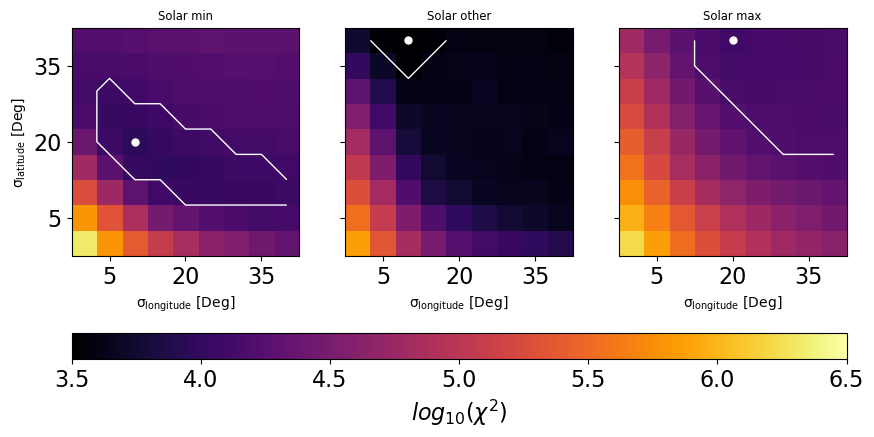

In [56]:


fig, axes = plt.subplots(ncols = 3, nrows = 1, figsize = (10,10), sharex = True, sharey = True)
axes = axes.flatten()

lat_dev_list = [0,5,10,15,20,25,30,35,40]
long_dev_list = np.linspace(0,40,len(lat_dev_list))

for i, key in enumerate(CR_chunk_key):

    rank_hist = rank_histogram_grids[i]

    im = axes[i].imshow(np.log10(rank_hist), cmap='inferno', origin = 'lower', vmin = 3.5, vmax = 6.5) 

    grid_range = np.max(np.log10(rank_hist)) - np.min(np.log10(rank_hist))
    within_5percent_of_min = np.log10(rank_hist) < np.min(np.log10(rank_hist)) + grid_range*0.05
    mindex = np.argwhere(np.log10(rank_hist)== np.min(np.log10(rank_hist)))[0]
    axes[i].plot(mindex[1], mindex[0], marker = 'o', markersize = 5, color = 'white')

    contours = axes[i].contour(within_5percent_of_min, levels = [0.5], colors='white', corner_mask = False, linewidths=1, label = r'$\mathrm{10^th percentile range}$')
    axes[i].set_title(f'Solar {key}', fontsize = 'small')


axes[0].set_yticks(np.arange(len(lat_dev_list))[1::3])
axes[0].set_ylabel(r'$\mathrm{\sigma_{latitude}}$ [Deg]', fontsize = 'medium')
axes[0].set_yticklabels(np.array([str(x) for x in lat_dev_list])[1::3])

outer_x_index = [0,1,2]
for x in outer_x_index:
    axes[x].set_xticks(np.arange(len(long_dev_list))[1::3])
    axes[x].set_xlabel(r'$\mathrm{\sigma_{longitude}}$ [Deg]', fontsize = 'medium')
    axes[x].set_xticklabels(np.array([f'{x:.0f}' for x in long_dev_list])[1::3], rotation = 0)

# Create a single colorbar for all subplots
cbar = fig.colorbar(im, ax=axes, pad=0.1, orientation = 'horizontal', aspect = 30) #, anchor = (-2,-2), aspect = 30)  
cbar.set_label(f'$log_{{10}}(\chi^2)$')

#fname = "C:\\Users\\ct832900\\OneDrive - University of Reading\\Spate Presentation Feb 2024\\Figures\\chisquaredsolarcycle.svg"
#plt.savefig(fname, format = 'svg', dpi = 300,bbox_inches='tight')
#plt.tight_layout()
plt.show()